# Linear regression comparison of tools

In [1]:
import pandas as pd
from pathlib import Path
from freyja_plot import FreyjaPlotter
import scipy.cluster
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections

## Collect lineage information for all tools in a FreyjaPlotter

## Collect lineage/abundance info for all samples for all tools

In [2]:
def renameSamples(plotter:FreyjaPlotter, rename:dict):
    """Renames samples and drops excluded samples"""
    # for samples like MixtureXX_barcodeYY, only keep the mixture number
    plotter.freyja_df["Sample name"] = plotter.freyja_df["Sample name"].apply(lambda x: x.split("_")[0])
    plotter.summarized_freyja_df["Sample name"] = plotter.summarized_freyja_df["Sample name"].apply(lambda x: x.split("_")[0])
    # drop NFWs and samples that we think had issues
    mixtures2drop = ["Mixture19", "Mixture20","Mixture41", "Mixture42", "NFWC", "NFWA"]
    plotter.freyja_df= plotter.freyja_df[~plotter.freyja_df["Sample name"].isin(mixtures2drop)]
    plotter.summarized_freyja_df= plotter.summarized_freyja_df[~plotter.summarized_freyja_df["Sample name"].isin(mixtures2drop)]
    # rename samples to lineage-related naming scheme
    plotter.freyja_df["Sample name"] = plotter.freyja_df["Sample name"].apply(lambda x: rename[x])
    plotter.freyja_df = plotter.freyja_df.sort_values(by="Sample name")
    plotter.summarized_freyja_df["Sample name"] = plotter.summarized_freyja_df["Sample name"].apply(lambda x: rename[x])
    plotter.summarized_freyja_df = plotter.summarized_freyja_df.sort_values(by="Sample name")
    return plotter

summary_dict = {
    "B": "Wuhan-hu-1",
    "BA.1.*": "BA.1.X",
    "BA.2.*": "BA.2.X",
    "BA.2.12.1.*": "BG.X",
    "BG.*": "BG.X",
    "BA.4.*": "BA.4.X",
    "BA.5.*": "BA.5.X",
    "BF.*": "BA.5.X",
}

mixture_renames = {
    'Mixture01': '0ADGIO1O2O3O4O5', 'Mixture02': '0ADGIO1', 'Mixture03': 'O2O3O4O5',
    'Mixture04': '0AGIO1O2', 'Mixture05': '0O5O3O4', 'Mixture06': 'ADGIO1O2O3',
    'Mixture07': 'AGIO3O4O5', 'Mixture08': 'O1O2O3O4O5', 'Mixture09': '0',
    'Mixture10': 'O1O2', 'Mixture11': 'O3', 'Mixture12': 'O5','Mixture13': 'O4', 
    'Mixture14': '0-2', 'Mixture15': 'A', 'Mixture16': 'G', 'Mixture17': 'I', 
    'Mixture18': 'D', 'Mixture19': 'O1', 'Mixture20': 'O2', 'Mixture21': '0-3',
    'Mixture22': 'O3-2', 'Mixture23': 'O3-3', 'Mixture24': 'O5-2', 'Mixture25': 'O5-3', 
    'Mixture26': 'O4-2', 'Mixture27': 'O4-3', 'Mixture28': 'O2-2', 'Mixture29': 'O2O3O4O5-2', 
    'Mixture30': 'O2O3O4O5-3', 'Mixture31': '0ADGIO1-2', 'Mixture32': '0AIO1O2O3O4O5', 
    'Mixture33': '0-4', 'Mixture34': 'A-2','Mixture35': 'G-2', 'Mixture36': 'I-2', 
    'Mixture37': 'D-2', 'Mixture38': 'O1-2', 'Mixture39': 'O2-3', 'Mixture40': 'O3-4',
    'Mixture41': 'O5-4', 'Mixture42': 'O4-4'
}
mixture_renames = {m:n.lower() for m,n in mixture_renames.items()}

benchmark_dir = Path("./../..").absolute().resolve()
expected = benchmark_dir / "expected_abundances/control_only_no_nfw_agg.tsv"
tools_dir = benchmark_dir / "tools"
runs = {
    "Alcov": {
        "WB":   tools_dir / "alcov/agg/alcov-05-05-23-V2.tsv",
        "NWRB": tools_dir / "alcov/agg/alcov-05-16-23-V2.tsv",
        "PWRB": tools_dir / "alcov/agg/alcov-07-12-23-V2A.tsv",
    },
    "Freyja": {
        "WB":   tools_dir / "freyja/agg/freyja-aggregated-05-05-23-V2.tsv",
        "NWRB": tools_dir / "freyja/agg/freyja-aggregated-05-16-23-V2.tsv",
        "PWRB": tools_dir / "freyja/agg/freyja-aggregated-07-12-23-V2A.tsv",
    },
    "kallisto": {
        "WB":   tools_dir / "kallisto/agg/kallisto-05-05-23-V2.tsv",
        "NWRB": tools_dir / "kallisto/agg/kallisto-05-16-23-V2.tsv",
        "PWRB": tools_dir / "kallisto/agg/kallisto-07-12-23-V2A.tsv",
    },
    "kallisto (C-WAP)": {
        "WB":   tools_dir / "kallisto-cwap/agg/05-05-23-V2.tsv",
        "NWRB": tools_dir / "kallisto-cwap/agg/05-16-23-V2.tsv",
        "PWRB": tools_dir / "kallisto-cwap/agg/07-12-23-V2A.tsv",
    },
    "Kraken 2 (C-WAP)": {
        "WB":   tools_dir / "kraken2-cwap/agg/05-05-23-V2.tsv",
        "NWRB": tools_dir / "kraken2-cwap/agg/05-16-23-V2.tsv",
        "PWRB": tools_dir / "kraken2-cwap/agg/07-12-23-V2A.tsv",
    },
    "LCS": {
        "WB":   tools_dir / "lcs/agg/lcs-05-05-23-V2.tsv",
        "NWRB": tools_dir / "lcs/agg/lcs-05-16-23-V2.tsv",
        "PWRB": tools_dir / "lcs/agg/lcs-07-12-23-V2A.tsv",
    },
    "lineagespot": {
        "WB":   tools_dir / "lineagespot/agg/lineagespot-05-05-23-V2.tsv",
        "NWRB": tools_dir / "lineagespot/agg/lineagespot-05-16-23-V2.tsv",
        "PWRB": tools_dir / "lineagespot/agg/lineagespot-07-12-23-V2A.tsv",
    },
    "LolliPop": {
        "WB":   tools_dir / "lollipop/agg/lollipop-05-05-23-V2.tsv",
        "NWRB": tools_dir / "lollipop/agg/lollipop-05-16-23-V2.tsv",
        "PWRB": tools_dir / "lollipop/agg/lollipop-07-12-23-V2A.tsv",
    },
    "VaQuERo": {
        "WB":   tools_dir / "vaquero/agg/05-05-23-V2-aggregated.tsv",
        "NWRB": tools_dir / "vaquero/agg/05-16-23-V2-aggregated.tsv",
        "PWRB": tools_dir / "vaquero/agg/07-12-23-V2A-aggregated.tsv",
    },
}

file_map = {expected:"Expected"}
for tool, files in runs.items():
    for name,file in files.items():
        if "WB" == name:
            file_map[file] = tool
plotter = FreyjaPlotter(
    file_map=file_map,
    # colormap=colormap,
    summary_dict=summary_dict,
)
plotter = renameSamples(plotter, rename=mixture_renames)
df = plotter.summarized_freyja_df.rename(columns={"Sample name":"sample","abundances":"abundance","scheme":"tool","lineages":"lineage"})
df

,sample,lineage,abundance,tool
666,0,BA.5.X,0.0088,kallisto
669,0,Lambda,0.0064,kallisto
1507,0,Beta,0.0050,kallisto (C-WAP)
1506,0,BA.4.X,0.0060,kallisto (C-WAP)
1505,0,BA.1.X,0.0060,kallisto (C-WAP)
...,...,...,...,...
1007,o5-3,Eta,0.0021,kallisto
1006,o5-3,Alpha,0.0025,kallisto
1005,o5-3,Epsilon,0.0026,kallisto
1739,o5-3,BA.2.X,0.0290,kallisto (C-WAP)


## Gather L2 median results in an array

In [3]:
lineages = set(df["lineage"].unique())
l2_tools = set(runs.keys())
l2s = []

# for each sample, calculate l2 array for the tools
for sample in set(df["sample"].unique()) - {None}:
    sample_df = df.loc[df['sample'] == sample, ('tool', 'lineage', 'abundance')]
    
    pivoted_sample_df = sample_df.pivot_table(index='lineage', columns='tool', values='abundance').fillna(0).T

    # for any missing tool, append 0-abundance df to bottom
    dfs2append = []
    missing_tools = l2_tools - set(pivoted_sample_df.index.unique())
    for tool in missing_tools:
        dfs2append.append(
            pd.DataFrame({lin:[0] for lin in lineages},index=[tool])
        )
    if dfs2append:
        pivoted_sample_df = pd.concat([pivoted_sample_df]+dfs2append).fillna(0)

    Y = squareform(pdist(pivoted_sample_df, 'euclidean'))
    l2s.append(Y)

# get order of tools, as they appear in the l2s
l2_index = pivoted_sample_df.index

# combine l2 results into a single condenced array
l2s_stacked = np.stack(l2s)
l2m = np.median(l2s_stacked, axis=0)
l2m

array([[0.        , 0.06906307, 0.05346641, 1.00147613, 0.08554811,
        0.22344088, 0.07638611, 0.31666566, 0.19227426, 1.10853603],
       [0.06906307, 0.        , 0.03138031, 1.04488532, 0.17167085,
        0.35694468, 0.10942324, 0.31684009, 0.28494647, 1.14554592],
       [0.05346641, 0.03138031, 0.        , 0.93105816, 0.17407882,
        0.31289764, 0.09033967, 0.32980962, 0.29811199, 1.15392233],
       [1.00147613, 1.04488532, 0.93105816, 0.        , 0.91652366,
        0.45756581, 0.81448035, 0.71083191, 0.73691772, 1.07275588],
       [0.08554811, 0.17167085, 0.17407882, 0.91652366, 0.        ,
        0.2681427 , 0.12319002, 0.31525007, 0.23695229, 1.0764156 ],
       [0.22344088, 0.35694468, 0.31289764, 0.45756581, 0.2681427 ,
        0.        , 0.35041623, 0.28929315, 0.22760437, 1.02081238],
       [0.07638611, 0.10942324, 0.09033967, 0.81448035, 0.12319002,
        0.35041623, 0.        , 0.30975731, 0.28877233, 1.09229846],
       [0.31666566, 0.31684009, 0.3298096

## Reorder array: lowest to highest (best to worst)

In [4]:
expected_vs_tools = list(l2m[0])
if len(set(expected_vs_tools)) < len(expected_vs_tools):
    raise Exception("Can't sort things when any values are duplicated")
idx = [expected_vs_tools.index(x) for x in sorted(expected_vs_tools)]
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]
l2m_clustered

array([[0.        , 0.05346641, 0.06906307, 0.07638611, 0.08554811,
        0.19227426, 0.22344088, 0.31666566, 1.00147613, 1.10853603],
       [0.05346641, 0.        , 0.03138031, 0.09033967, 0.17407882,
        0.29811199, 0.31289764, 0.32980962, 0.93105816, 1.15392233],
       [0.06906307, 0.03138031, 0.        , 0.10942324, 0.17167085,
        0.28494647, 0.35694468, 0.31684009, 1.04488532, 1.14554592],
       [0.07638611, 0.09033967, 0.10942324, 0.        , 0.12319002,
        0.28877233, 0.35041623, 0.30975731, 0.81448035, 1.09229846],
       [0.08554811, 0.17407882, 0.17167085, 0.12319002, 0.        ,
        0.23695229, 0.2681427 , 0.31525007, 0.91652366, 1.0764156 ],
       [0.19227426, 0.29811199, 0.28494647, 0.28877233, 0.23695229,
        0.        , 0.22760437, 0.3179826 , 0.73691772, 1.10261405],
       [0.22344088, 0.31289764, 0.35694468, 0.35041623, 0.2681427 ,
        0.22760437, 0.        , 0.28929315, 0.45756581, 1.02081238],
       [0.31666566, 0.32980962, 0.3168400

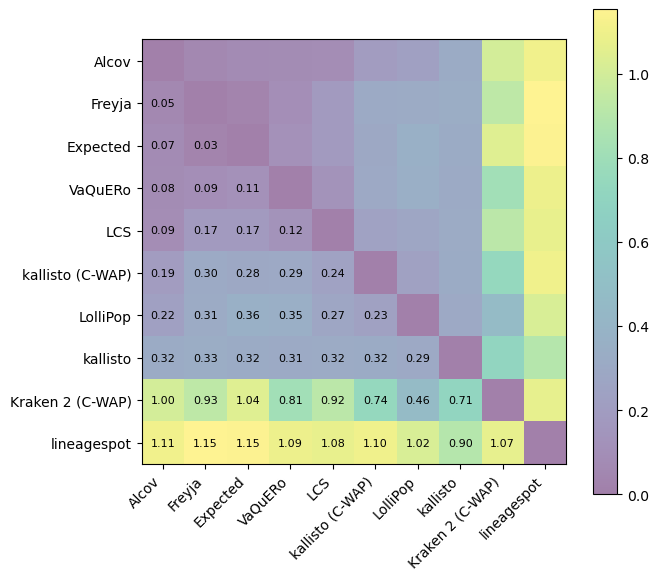

In [5]:
# plot
fig, (ax2) = plt.subplots(
    1, 1, figsize=(6.85, 9), 
    # gridspec_kw = {'height_ratios':[6.8]}
    )

N = len(l2_index)

ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)

for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax2.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

cmap = matplotlib.colormaps.get_cmap('viridis') # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

im = ax2.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax2, shrink=0.7)

ax2.set_xticks(np.arange(N))
ax2.set_yticks(np.arange(N))
ax2.set_xticklabels(l2_index[idx], rotation=45, ha='right')
ax2.set_yticklabels(l2_index[idx])
fig.set_constrained_layout_pads(hspace=-0.10, h_pad=0, wspace=0, w_pad=0)

fig.savefig('L2_matrix_varskip.png', bbox_inches='tight')
# fig.savefig('L2_matrix_varskip.pdf', bbox_inches='tight')
# fig.savefig('L2_matrix_varskip.svg', bbox_inches='tight')
